In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/img-data-branded/not_real_imgs.npy
/kaggle/input/img-data-branded/real_imgs.npy


In [2]:
not_real=np.load("/kaggle/input/img-data-branded/not_real_imgs.npy")
real=np.load("/kaggle/input/img-data-branded/real_imgs.npy")

In [3]:
data=np.concatenate((not_real,real),axis=0)

In [4]:
labels=np.concatenate(([0]*not_real.shape[0],[1]*np.ones(real.shape[0])),axis=0)

In [5]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
del data,labels

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
def value_counts(arr):
    n=len(arr)
    cnt_0,cnt_1=(0,0)
    for x in arr:
        if x==1:
            cnt_1+=1
        else:
            cnt_0+=1
    print("0 ->",cnt_0,"that is",(cnt_0/n)*100,"%")
    print("1 ->",cnt_1,"that is",(cnt_1/n)*100,"%")
        
    

In [7]:
print("train label distribution")
value_counts(train_labels)

train label distribution
0 -> 23347 that is 65.8236770137303 %
1 -> 12122 that is 34.1763229862697 %


In [8]:
print("test label distribution")
value_counts(test_labels)


test label distribution
0 -> 5853 that is 66.00135317997294 %
1 -> 3015 that is 33.99864682002706 %


In [9]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(train_labels),
                                                 y=train_labels.ravel())


In [10]:
class_weights

array([0.75960509, 1.46300115])

In [11]:
train_data.shape

(35469, 48, 48, 3)

In [12]:
test_data.shape

(8868, 48, 48, 3)

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [14]:
from keras.metrics import Precision, Recall, AUC
metrics_ = [ AUC(name='auc'), 
    'accuracy', 
    Precision(name="precision"),
    Recall(name="recall")]


In [15]:
model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics= metrics_)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [16]:
#train_data, test_data, train_labels, test_labels

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(train_data, train_labels, 
                    batch_size=32, 
                    epochs=10,validation_split = 0.2,
                    class_weight={0:class_weights[0],1:class_weights[1]})


Epoch 1/10
887/887 [==============================] - 17s 9ms/step - loss: 0.0039 - auc: 1.0000 - accuracy: 0.9993 - precision: 0.9980 - recall: 1.0000 - val_loss: 4.3914e-09 - val_auc: 1.0000 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/10
887/887 [==============================] - 8s 9ms/step - loss: 1.2375e-08 - auc: 1.0000 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.2479e-08 - val_auc: 1.0000 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
887/887 [==============================] - 8s 9ms/step - loss: 1.6009e-08 - auc: 1.0000 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.2972e-08 - val_auc: 1.0000 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/10
887/887 [==============================] - 7s 8ms/step - loss: 1.5207e-08 - auc: 1.0000 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 9.8393e-09 - val_auc: 1.0000 - val_accuracy:

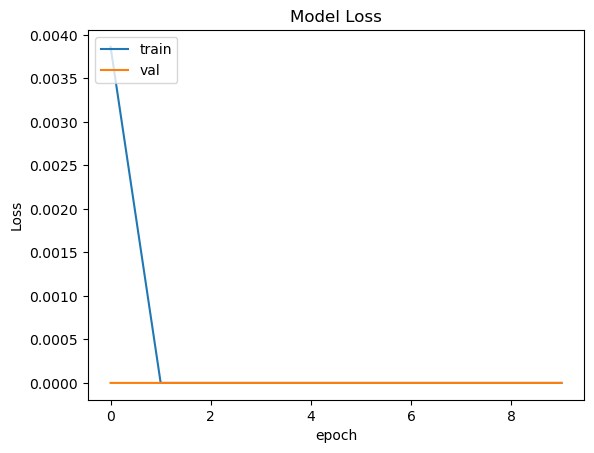

In [18]:
import matplotlib.pyplot as plt
history.history.keys()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [22]:
test_data.shape

(8868, 48, 48, 3)

In [23]:
test_labels.shape

(8868,)

In [19]:
y_pred=model.predict(test_data)

preds=np.where(y_pred> 0.50, 1, 0)


278/278 [==============================] - 1s 2ms/step


In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
target_names = ['Class 0', 'Class 1']

report = classification_report(test_labels, preds, target_names=target_names)
print(report)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      5853
     Class 1       1.00      1.00      1.00      3015

    accuracy                           1.00      8868
   macro avg       1.00      1.00      1.00      8868
weighted avg       1.00      1.00      1.00      8868



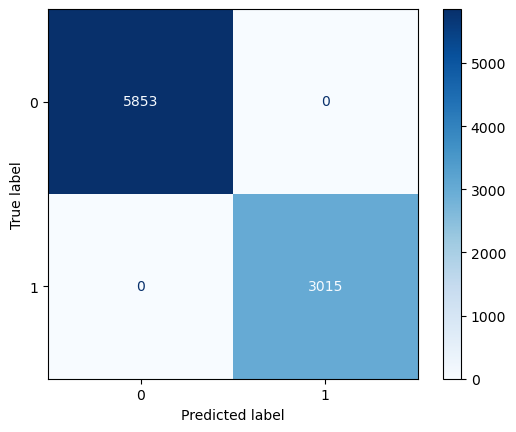

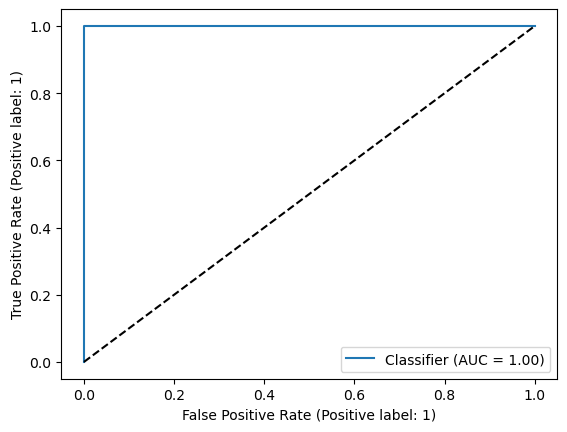

In [21]:
#plotting confusion matrix
cm=confusion_matrix(test_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

#printing ROC curve
RocCurveDisplay.from_predictions(
    test_labels,
    y_pred
)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")